In [37]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import BSpline
import numpy as np
import matplotlib.pyplot as plt
from skspatial.objects import Line

np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [31]:
def get_shortest_distance_from_point_to_segment(point, seg_start, seg_end):
    """
    Calculates the shortest distance from a point to a line segment defined by seg_start and seg_end.
    """
    lineseg = Line.from_points(seg_start, seg_end)
    projpt = lineseg.project_point(point)
    if projpt[0] < min(seg_start[0], seg_end[0]) or projpt[0] > max(seg_start[0], seg_end[0]) or \
       projpt[1] < min(seg_start[1], seg_end[1]) or projpt[1] > max(seg_start[1], seg_end[1]) or \
        projpt[2] < min(seg_start[2], seg_end[2]) or projpt[2] > max(seg_start[2], seg_end[2]):
        # If the projection point is outside the segment, return the distance to the nearest endpoint
        dist_to_start = np.linalg.norm(np.array(point) - np.array(seg_start))
        dist_to_end = np.linalg.norm(np.array(point) - np.array(seg_end))
        return min(dist_to_start, dist_to_end)
    else:
        # If the projection point is on the segment, return the distance to the projection point
        return lineseg.distance_point(point)

In [44]:
def compare_curve_to_segments(curve, segments):
    """
    Compares a subset of points on a B-spline curve to a set of line segments that represents that curve. 
    Returns a metric of how well the curve approximates the segments, right now in MSE.
    """
    mse = 0
    for point in curve:
        dist_to_segs = []
        for i in range(len(segments) - 1):
            seg_start = segments[i]
            seg_end = segments[i + 1]
            dist_to_segs.append(get_shortest_distance_from_point_to_segment(point, seg_start, seg_end))
            # print(f"Distance from point {point} to segment {i} is {dist_to_segs[i]:.3f}")

        # print(f"Minimum distance for point {point} to branch is {min(dist_to_segs):.3f}")
        mse += min(dist_to_segs)**2
    return mse / len(curve)  # Average MSE over all sampled points

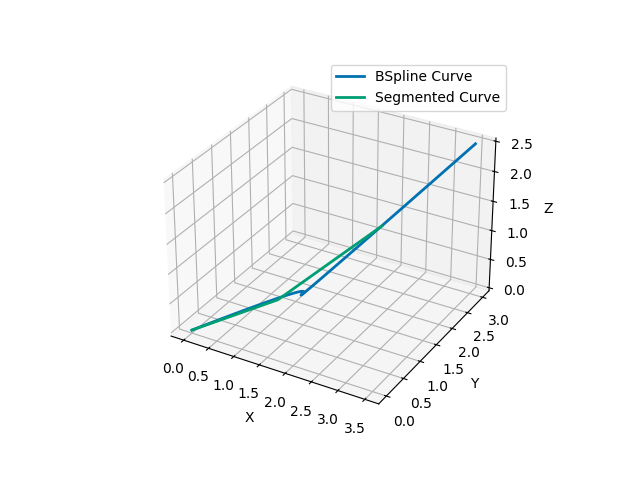

In [45]:
# Degree of the spline
k = 2

# Knot vector (must be non-decreasing, length = n_control_points + k + 1)
t = [0, 0, 0, 1, 2, 3, 3]

# 4 control points in 3D
c = np.array([
    [0, 0, 0],
    [1, 2, 0],
    [2, 0, 1],
    [3, 1, 2]
])

baseline = np.array([
    [0, 0, 0],
    [1, 1, 0.25],
    [3, 1, 2],
])

def plot_segmented_curve(ax, segs, color='#009E73', label='Segmented Curve'):
    """Plots a segmented curve given a list of segment end points."""
    if segs.shape[1] != 3:
        raise ValueError("Segments must be 3D (shape: n_segments x 3)")
    ax.plot(segs[:, 0], segs[:, 1], segs[:, 2], color=color, lw=2, label=label)

# Create a BSpline for each dimension
spl_x = BSpline(t, c[:, 0], k)
spl_y = BSpline(t, c[:, 1], k)
spl_z = BSpline(t, c[:, 2], k)

# Parameter values for evaluation
u = np.linspace(0, 3, 100)
curve = np.vstack((spl_x(u), spl_y(u), spl_z(u))).T

judgement_points = np.linspace(0, 3, 20)
judgement_curve = np.vstack((spl_x(judgement_points), spl_y(judgement_points), spl_z(judgement_points))).T

MSE = compare_curve_to_segments(judgement_curve, baseline)
     
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(curve[:, 0], curve[:, 1], curve[:, 2], color='#0072B2', lw=2, label='BSpline Curve')

# Plot control points and control polygon
# ax.plot(c[:, 0], c[:, 1], c[:, 2], 'o--', color='#E69F00', label='Control Points')
plot_segmented_curve(ax, baseline)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(loc='best')
plt.show()